# Multi Agent Collaboration Network 

- Author: [Youngin Kim](https://github.com/Normalist-K)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

In this tutorial, we'll explore how to implement a **multi-agent network** using LangGraph.  
A multi-agent network is an architecture that leverages a "divide-and-conquer" approach by breaking down complex tasks into smaller, specialized agents. 

This helps resolve the inefficiencies of a single agent managing numerous tools, allowing each agent to focus on its area of expertise and solve problems effectively.

Inspired by the [AutoGen paper](https://arxiv.org/abs/2308.08155), this tutorial walks you through the process of building such multi-agent networks with LangGraph step-by-step. 

![network](./assets/17-langgraph-multi-agent-network.png)

**Key Topics Covered**

- **Defining States** : How to define graph states and manage the state information required for each agent's actions  
- **Defining Tools** : How to specify tools that agents can use and add them as nodes  
- **Creating Agents** : How to define agents and set them as nodes in a LangGraph network  
- **Defining Agent Nodes** : How to define specialized agents as nodes  
- **Defining Tool Nodes** : How to define tools as nodes and enable agents to utilize them  
- **Defining Edge Logic** : How to set branching logic that directs agents or tools based on the results of an agent’s task  
- **Graph Definition** : How to combine agents, tools, states, and edge logic into a cohesive graph  
- **Running the Graph** : How to execute the graph and perform real-world tasks with the defined setup  

Let's get started!


### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Why Do We Use Multi-Agent Networks?](#why-do-we-use-multi-agent-networks)
- [Defining States](#defining-states)
- [Defining Tools](#defining-tools)
- [Creating Agents](#creating-agents)
- [Building a Multi-Agent Graph](#building-a-multi-agent-graph)
- [Running the Agents](#running-the-agents)

### References

- [Concept of Multi Agent Network LangGraph](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network)  
- [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation (Wu et al.)](https://arxiv.org/abs/2308.08155)  
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [2]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [4]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_experimental",
        "langchain_openai",
        "langgraph",
        "tavily-python",  # for web search tool
        "matplotlib",  # for visualize tool
        "pandas",  # for visualize tool
        "numpy",  # for visualize tool
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [4]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "TAVILY_API_KEY": "",  # for tavily web search tool
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "Multi-Agent-Collaboration",
        }
    )

## Why Do We Use Multi-Agent Networks?

A single agent can be efficient when working within a specific domain and using a limited number of tools. However, as the number of tools increases, several challenges arise:  
1. The logic for managing tools becomes increasingly complex.  
2. The amount of information the agent needs to process at once grows, leading to inefficiencies.

By adopting a "divide-and-conquer" approach, each agent focuses on a specific task or area of expertise, while the overall workload is distributed across a network.  
Each agent handles what it does best and delegates tasks to other specialized agents or utilizes tools effectively when needed.

This structure enhances efficiency and simplifies the management of complex workflows.

## Defining States

`messages` is a list of messages shared between agents, and `sender` refers to the sender of the most recent message.

In [5]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage


# Defining state
class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  # a list of messages shared between agents
    sender: Annotated[str, "The sender of the last message"]

## Defining Tools

Here, we define a few tools that agents will use in the network:

- `TavilySearch` : A tool for searching information on the internet. It is used by the `research_agent` to find the necessary data.  
- `PythonREPL` : A tool for executing Python code. It is used by the `chart_agent` to create charts.  

In [6]:
from typing import Annotated

from multi_agent_collaboration import TavilySearch
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Defining tavily web search tool
tavily_tool = TavilySearch(max_results=5)

# Defining a tool for executing python code
python_repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = python_repl.run(code)
    except BaseException as e:
        return f"Failed to execute code. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Creating Agents

Here’s an example of how to create agents. In this tutorial, we’ll use the Research Agent and the Chart Generator Agent to build a multi-agent network.


First, define the LLM model and a common system prompt to be used for the agents.

In [16]:
from langchain_openai import ChatOpenAI

# Defining LLM
llm = ChatOpenAI(model="gpt-4o")

In [8]:
# Defining common system prompt
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

### Research Agent

Create an agent that performs research using the `TavilySearch` tool. This agent is used to gather the required information.

In [9]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState


research_agent_system_prompt = """
You can only do research. You are working with a chart generator colleague.
"""

# Create Research Agent
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(research_agent_system_prompt),
)


# Defining Research Agent Node
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        "messages": [last_message],
    }

### Chart Generator Agent

Create an agent that generates charts using the `PythonREPL` tool. This agent is used to create charts.

In [10]:
chart_generator_system_prompt = """
You can only generate charts. You are working with a researcher colleague.
Be sure to use the following font code in your code when generating charts.
"""

# Create Chart Generator Agent
chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    state_modifier=make_system_prompt(chart_generator_system_prompt),
)


# Defining Chart Generator Agent Node
def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)

    last_message = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        "messages": [last_message],
    }

## Building a Multi-Agent Graph

This workflow uses LangGraph to build a **multi-agent system** where agents collaborate dynamically. 

The `router` decides the next step by analyzing messages—either continuing to the next node or ending the workflow. 

Each node, like `researcher` and `chart_generator`, is connected using **conditional edges** that determine the workflow’s flow based on the router's logic. The system starts with the `researcher` and alternates between agents until a "FINAL ANSWER" is reached.

In [11]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# Defining Router
def router(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"


# Building a multi-agent network workflow
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
app = workflow.compile(checkpointer=MemorySaver())

Let's take a look at the graph we’ve created by visualizing it!

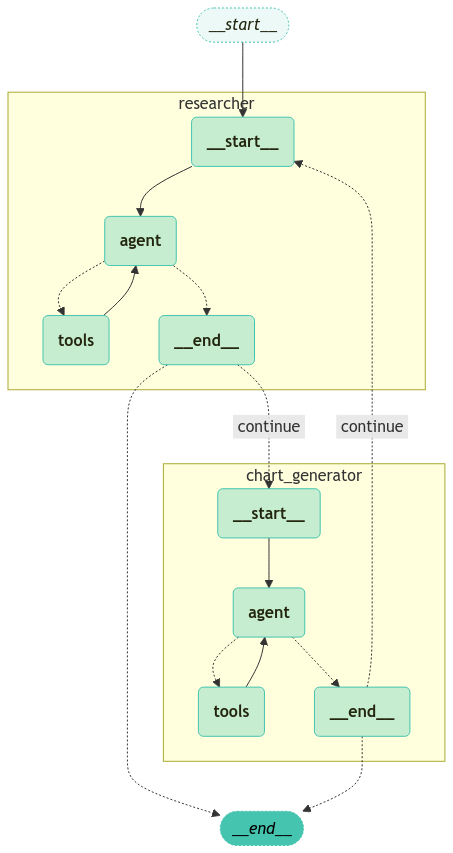

In [12]:
from multi_agent_collaboration import visualize_graph

visualize_graph(app, xray=True)

## Running the Agents

Now it’s time to execute the multi-agent workflow we’ve built! 

Using the `RunnableConfig`, we set up necessary configurations like recursion limits and unique thread IDs. 

Then, we input a query and invoke the graph, allowing the agents to collaborate and generate results based on the workflow.


Here’s an example of code that visualizes CO2 emissions from 2015 to 2024. If you’re curious about something else, try changing the query and see how well the agents handle it!

[NOTE] As of January 22 2025, GPT-4o's maximum context length is 128,000 tokens. Depending on the query, you might exceed this limit and encounter an error. If that happens, consider refining the agent graph or modifying your query.


🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_CFdK4CfIoJxX5kIoYguSXi0p)
 Call ID: call_CFdK4CfIoJxX5kIoYguSXi0p
  Args:
    query: global CO2 emissions data 2015 to 2024

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_MwlrAdIEdFPINKXPcY5l6RPz)
 Call ID: call_MwlrAdIEdFPINKXPcY5l6RPz
  Args:
    query: global CO2 emissions from 2015 to 2024 chart
  tavily_web_search (call_JXa5Yzg224W3O33ngymXHKfm)
 Call ID: call_JXa5Yzg224W3O33ngymXHKfm
  Args:
    query: global carbon dioxide emissions data 2015-2024 by year

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

I've gat

Python REPL can execute arbitrary code. Use with caution.



🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  python_repl_tool (call_2IABgdWp7pUnCFJtTml6gVNg)
 Call ID: call_2IABgdWp7pUnCFJtTml6gVNg
  Args:
    code: import matplotlib.pyplot as plt

# Data for CO2 emissions from 2015 to 2024
years = list(range(2015, 2025))
emissions = [36.5, 36.5, 36.8, 37.1, 37.2, 35.9, 37.4, 37.55, 37.8, 41.6]  # in billion metric tons

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(years, emissions, marker='o', linestyle='-', color='b')
plt.title('Global CO2 Emissions (2015-2024)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (billion metric tons)')
plt.xticks(years)
plt.grid(True)
plt.show()


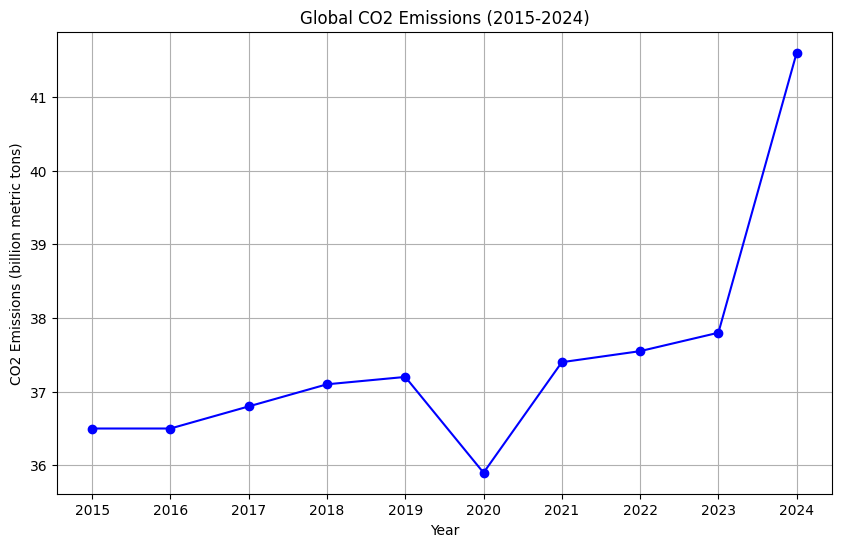


🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Here is the visualization of the global CO2 emissions trend from 2015 to 2024:

![CO2 Emissions Trend](sandbox://generated-image)

This chart illustrates the progression of CO2 emissions over the years, highlighting the significant drop in 2020 due to the COVID-19 pandemic and the subsequent rebound in emissions. The projections for 2023 and 2024 indicate a continued rise in emissions.

FINAL ANSWER

🔄 Node: chart_generator 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: chart_generator

Here is the visualization of the global CO2 emissions trend from 2015 to 2024:

![CO2 Emissions Trend](sandbox://generated-image)

This chart illustrates the progression of CO2 emissions over the years, highlighting the significant drop in 2020

In [15]:
from langchain_core.runnables import RunnableConfig
from multi_agent_collaboration import random_uuid, invoke_graph

# set up config (recursion_limit, thread_id)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": random_uuid()})

# input query
inputs = {
    "messages": [
        HumanMessage(
            content="visualize the trend of CO2 emissions worldwide from 2015 to 2024."
        )
    ],
}

# invoke graph
invoke_graph(app, inputs, config, node_names=["researcher", "chart_generator", "agent"])